In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import tarfile
import pathlib
import PIL.Image

In [2]:
tf.get_logger().setLevel("ERROR")

In [3]:
DATASETS_DIR = "data"
DATASETS_TGZ = "datasets.tgz"
UNPACKED_DIR = os.path.join("data", "unpacked")

In [4]:
os.makedirs(UNPACKED_DIR, exist_ok=True)
tgz_path = os.path.join(DATASETS_DIR, DATASETS_TGZ)
dataset_tgz = tarfile.open(tgz_path)
dataset_tgz.extractall(path=UNPACKED_DIR)
dataset_tgz.close()

In [5]:
def read_csv_dataset(name, path=UNPACKED_DIR):
    csv_path = os.path.join(path, name + ".csv")
    return pd.read_csv(csv_path)

titanic_ds = read_csv_dataset("Titanic")
diamonds_ds = read_csv_dataset("diamonds")

In [6]:
def read_images_dataset(name, path=UNPACKED_DIR, image_size=32, train_split=0.75, val_split=0.15):
    test_split = 1 - train_split - val_split
    train_ds, val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, name),
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        image_size=(image_size, image_size),
        batch_size=32,
        seed=42,
        shuffle=True,
        validation_split=val_split + test_split,
        subset="both"
    )
    classes = train_ds.class_names
    train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_test_ds = val_test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
    train_ds = train_ds.map(lambda x, y: (rescale(x), y))
    val_test_ds = val_test_ds.map(lambda x, y: (rescale(x), y))
    
    size = len(val_test_ds)
    val_ds = val_test_ds.take(int(size * (val_split / (val_split + test_split))))
    test_ds = val_test_ds.skip(int(size * (val_split / (val_split + test_split))))
    
    return train_ds, val_ds, test_ds, classes

image_size = 128
weather_ds = read_images_dataset("weather-image", image_size=image_size)

Found 6862 files belonging to 11 classes.
Using 5147 files for training.
Using 1715 files for validation.


## From Biological to Artificial Neurons

#### The Perceptron

In [7]:
from sklearn.linear_model import Perceptron

titanic_ds.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
titanic_ds["Sex"] = (titanic_ds["Sex"] == "male").astype(np.int32)
X, y = titanic_ds[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]], titanic_ds["Survived"]
X_train, X_test = X.iloc[5:], X.iloc[:5]
y_train, y_test = y.iloc[5:], y.iloc[:5]

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

per_clf = Perceptron(random_state=42, n_iter_no_change=100)
per_clf.fit(X_train, y_train)

y_pred = per_clf.predict(X_test)
y_pred

array([0, 1, 1, 1, 0], dtype=int64)

In [10]:
y_test

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Implementing MLPs (and CNN) with Keras

#### Building an Image Classifier Using the Sequential API

##### Using Keras to load the dataset

In [11]:
from tensorflow import keras

train_ds, valid_ds, test_ds, class_names = weather_ds
images_path = pathlib.Path(UNPACKED_DIR, "weather-image")

In [12]:
image_count = len(list(images_path.glob("*/*.*")))
image_count

6862

In [13]:
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


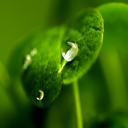

'dew'

In [14]:
image = PIL.Image.open(next(images_path.glob(class_names[0] + "/*"))).resize((image_size, image_size))
display(image)
class_names[0]

##### Creating the model using the Sequential API

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), input_shape=[image_size, image_size, 3], activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [18]:
model.layers

In [19]:
hidden3 = model.layers[3]
hidden3.name

'conv2d_1'

In [20]:
model.get_layer("conv2d_1") is hidden3

True

In [21]:
weights, biases = hidden3.get_weights()

In [22]:
weights.shape

(3, 3, 32, 64)

In [23]:
biases.shape

(64,)

##### Compiling the model

In [24]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

##### Training and evaluating the model

In [25]:
history = model.fit(train_ds, epochs=30, validation_data=valid_ds)

Epoch 1/30
161/161 [==============================] - 15s 88ms/step - loss: 2.1015 - accuracy: 0.2695 - val_loss: 1.8744 - val_accuracy: 0.3428
Epoch 2/30
161/161 [==============================] - 14s 88ms/step - loss: 1.4700 - accuracy: 0.5013 - val_loss: 1.2591 - val_accuracy: 0.6055
Epoch 3/30
161/161 [==============================] - 14s 87ms/step - loss: 1.2971 - accuracy: 0.5514 - val_loss: 1.2871 - val_accuracy: 0.5225
Epoch 4/30
161/161 [==============================] - 14s 87ms/step - loss: 1.1863 - accuracy: 0.5860 - val_loss: 1.1203 - val_accuracy: 0.6279
Epoch 5/30
161/161 [==============================] - 14s 88ms/step - loss: 1.1235 - accuracy: 0.6132 - val_loss: 1.1251 - val_accuracy: 0.6250
Epoch 6/30
161/161 [==============================] - 14s 86ms/step - loss: 1.0849 - accuracy: 0.6252 - val_loss: 1.0603 - val_accuracy: 0.6475
Epoch 7/30
161/161 [==============================] - 14s 88ms/step - loss: 1.0413 - accuracy: 0.6408 - val_loss: 1.0596 - val_accuracy:

In [26]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 161}

In [27]:
len(history.epoch)

30

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

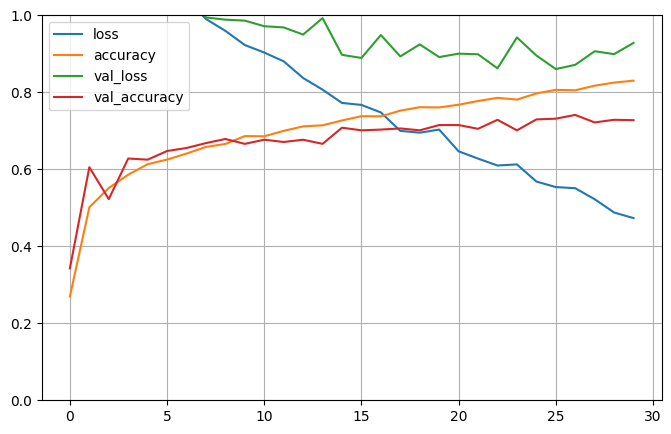

In [29]:
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [30]:
model.evaluate(test_ds)

22/22 [==============================] - 1s 25ms/step - loss: 0.8719 - accuracy: 0.7265


[0.8719432950019836, 0.7264833450317383]

##### Using the model to make predictions

In [31]:
new = test_ds.take(1)
proba = model.predict(new, verbose=0)[:5]
proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.  ],
       [0.  , 0.26, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.73, 0.  ],
       [0.  , 0.65, 0.01, 0.  , 0.  , 0.01, 0.  , 0.15, 0.08, 0.04, 0.05]],
      dtype=float32)

In [32]:
y_pred = np.argmax(model.predict(new, verbose=0), axis=-1)[:5]
y_pred

array([4, 8, 7, 9, 1], dtype=int64)

In [33]:
np.array(class_names)[y_pred]

array(['hail', 'rime', 'rainbow', 'sandstorm', 'fogsmog'], dtype='<U9')

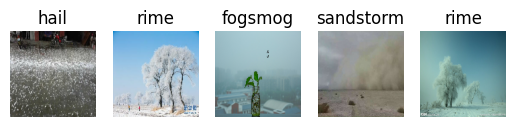

In [34]:
for x, y in new.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow((x[i].numpy()*255).astype("uint8"))
        plt.title(class_names[y.numpy()[i]])
        plt.axis("off")

#### Building a Regression MLP Using the Sequential API

In [35]:
diamonds_ds.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

diamonds_data, diamonds_target = diamonds_ds[["carat", "depth", "table", "x", "y", "z"]], diamonds_ds["price"]
X_train_full, X_test, y_train_full, y_test = train_test_split(diamonds_data, diamonds_target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [37]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam())
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
949/949 [==============================] - 1s 874us/step - loss: 30599706.0000 - val_loss: 27814372.0000
Epoch 2/20
949/949 [==============================] - 1s 748us/step - loss: 24773528.0000 - val_loss: 20283708.0000
Epoch 3/20
949/949 [==============================] - 1s 799us/step - loss: 16644484.0000 - val_loss: 12483144.0000
Epoch 4/20
949/949 [==============================] - 1s 749us/step - loss: 9484301.0000 - val_loss: 6838823.0000
Epoch 5/20
949/949 [==============================] - 1s 767us/step - loss: 4919025.0000 - val_loss: 4093709.0000
Epoch 6/20
949/949 [==============================] - 1s 749us/step - loss: 2986352.7500 - val_loss: 3412616.5000
Epoch 7/20
949/949 [==============================] - 1s 746us/step - loss: 2499380.0000 - val_loss: 3344294.2500
Epoch 8/20
949/949 [==============================] - 1s 761us/step - loss: 2384335.7500 - val_loss: 3283442.0000
Epoch 9/20
949/949 [==============================] - 1s 767us/step - loss: 232012

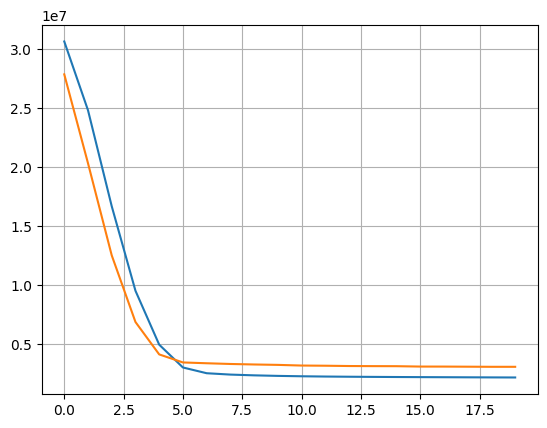

In [38]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [39]:
model.evaluate(X_test, y_test)

422/422 [==============================] - 0s 491us/step - loss: 2193872.5000


2193872.5

In [40]:
X_new = X_test[:3]
y_pred = model.predict(X_new, verbose=0)
y_pred

array([[ 796.8253],
       [1346.6681],
       [1040.8612]], dtype=float32)

In [41]:
y_new = y_test[:3]
y_new

1388      559
50052    2201
41645    1238
Name: price, dtype: int64

#### Building Complex Models Using the Functional API

In [42]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 30)                   210       ['input_1[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 30)                   930       ['dense_4[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 36)                   0         ['input_1[0][0]',             
                                                                     'dense_5[0][0]']         

In [44]:
input_A = keras.layers.Input(shape=[4], name="wide_input")
input_B = keras.layers.Input(shape=[3], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [45]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 deep_input (InputLayer)     [(None, 3)]                  0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 30)                   120       ['deep_input[0][0]']          
                                                                                                  
 wide_input (InputLayer)     [(None, 4)]                  0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 30)                   930       ['dense_7[0][0]']             
                                                                                            

In [46]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam())

X_train_A, X_train_B = X_train[:, :4], X_train[:, 3:]
X_valid_A, X_valid_B = X_valid[:, :4], X_valid[:, 3:]
X_test_A, X_test_B = X_test[:, :4], X_test[:, 3:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid));

Epoch 1/20
949/949 [==============================] - 1s 932us/step - loss: 23877512.0000 - val_loss: 6915601.5000
Epoch 2/20
949/949 [==============================] - 1s 840us/step - loss: 2663081.5000 - val_loss: 3469895.2500
Epoch 3/20
949/949 [==============================] - 1s 865us/step - loss: 2249525.0000 - val_loss: 3563605.7500
Epoch 4/20
949/949 [==============================] - 1s 834us/step - loss: 2217895.7500 - val_loss: 3609627.0000
Epoch 5/20
949/949 [==============================] - 1s 859us/step - loss: 2193296.2500 - val_loss: 3629470.2500
Epoch 6/20
949/949 [==============================] - 1s 879us/step - loss: 2174779.2500 - val_loss: 3640248.0000
Epoch 7/20
949/949 [==============================] - 1s 848us/step - loss: 2157827.2500 - val_loss: 3635088.7500
Epoch 8/20
949/949 [==============================] - 1s 871us/step - loss: 2144762.0000 - val_loss: 3689561.0000
Epoch 9/20
949/949 [==============================] - 1s 842us/step - loss: 2131891.500

In [47]:
model.evaluate((X_test_A, X_test_B), y_test)

422/422 [==============================] - 0s 574us/step - loss: 2316239.5000


2316239.5

In [48]:
y_pred = model.predict((X_new_A, X_new_B), verbose=0)
y_pred

array([[ 711.8309],
       [1982.1323],
       [ 936.3407]], dtype=float32)

In [49]:
input_A = keras.layers.Input(shape=[4], name="wide_input")
input_B = keras.layers.Input(shape=[3], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.Adam())
model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
          validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]));

Epoch 1/20
949/949 [==============================] - 1s 999us/step - loss: 23014188.0000 - main_output_loss: 22883758.0000 - aux_output_loss: 24187844.0000 - val_loss: 5909850.0000 - val_main_output_loss: 5736665.0000 - val_aux_output_loss: 7468559.0000
Epoch 2/20
949/949 [==============================] - 1s 897us/step - loss: 2525559.2500 - main_output_loss: 2490466.2500 - aux_output_loss: 2841411.2500 - val_loss: 3526841.0000 - val_main_output_loss: 3530247.7500 - val_aux_output_loss: 3496168.0000
Epoch 3/20
949/949 [==============================] - 1s 915us/step - loss: 2231093.2500 - main_output_loss: 2230912.2500 - aux_output_loss: 2232697.7500 - val_loss: 3617319.5000 - val_main_output_loss: 3617541.0000 - val_aux_output_loss: 3615327.5000
Epoch 4/20
949/949 [==============================] - 1s 886us/step - loss: 2204728.2500 - main_output_loss: 2204654.5000 - aux_output_loss: 2205414.0000 - val_loss: 3650522.2500 - val_main_output_loss: 3650529.0000 - val_aux_output_loss: 36

In [50]:
model.evaluate([X_test_A, X_test_B], [y_test, y_test]) # total_loss, main_loss, aux_loss

422/422 [==============================] - 0s 585us/step - loss: 2315124.0000 - main_output_loss: 2314993.5000 - aux_output_loss: 2316293.2500


[2315124.0, 2314993.5, 2316293.25]

In [51]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

(array([[ 697.19073],
        [2013.9595 ],
        [ 927.4189 ]], dtype=float32),
 array([[ 694.68304],
        [2012.5068 ],
        [ 921.87787]], dtype=float32))

#### Using the Subclassing API to Build Dynamic Models

In [52]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs, training=None, mask=None):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [53]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.Adam())
model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=20, 
          validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)));

Epoch 1/20
949/949 [==============================] - 1s 977us/step - loss: 23580288.0000 - output_1_loss: 23545150.0000 - output_2_loss: 23896538.0000 - val_loss: 6697311.5000 - val_output_1_loss: 6649078.0000 - val_output_2_loss: 7131403.5000
Epoch 2/20
949/949 [==============================] - 1s 896us/step - loss: 2636721.2500 - output_1_loss: 2627732.5000 - output_2_loss: 2717619.7500 - val_loss: 3490172.7500 - val_output_1_loss: 3490854.2500 - val_output_2_loss: 3484026.7500
Epoch 3/20
949/949 [==============================] - 1s 892us/step - loss: 2248307.0000 - output_1_loss: 2248254.2500 - output_2_loss: 2248765.5000 - val_loss: 3579495.7500 - val_output_1_loss: 3579393.2500 - val_output_2_loss: 3580429.7500
Epoch 4/20
949/949 [==============================] - 1s 902us/step - loss: 2222709.0000 - output_1_loss: 2222650.0000 - output_2_loss: 2223246.2500 - val_loss: 3616209.5000 - val_output_1_loss: 3616055.7500 - val_output_2_loss: 3617575.5000
Epoch 5/20
949/949 [=========

In [54]:
model.evaluate((X_test_A, X_test_B), (y_test, y_test)) # total_loss, main_loss, aux_loss

422/422 [==============================] - 0s 582us/step - loss: 2304862.7500 - output_1_loss: 2304675.0000 - output_2_loss: 2306549.0000


[2304862.75, 2304675.0, 2306549.0]

In [55]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

(array([[ 708.6035 ],
        [1981.1372 ],
        [ 954.72284]], dtype=float32),
 array([[ 707.92957],
        [1971.5621 ],
        [ 948.2606 ]], dtype=float32))

#### Saving and Restoring a Model

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [57]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid));

Epoch 1/10
949/949 [==============================] - 1s 888us/step - loss: 19312806.0000 - val_loss: 3555812.0000
Epoch 2/10
949/949 [==============================] - 1s 782us/step - loss: 2401374.0000 - val_loss: 3193594.0000
Epoch 3/10
949/949 [==============================] - 1s 828us/step - loss: 2232067.0000 - val_loss: 3144914.5000
Epoch 4/10
949/949 [==============================] - 1s 782us/step - loss: 2190053.2500 - val_loss: 3118802.0000
Epoch 5/10
949/949 [==============================] - 1s 785us/step - loss: 2166886.2500 - val_loss: 3060197.0000
Epoch 6/10
949/949 [==============================] - 1s 797us/step - loss: 2147356.2500 - val_loss: 3039215.7500
Epoch 7/10
949/949 [==============================] - 1s 831us/step - loss: 2130924.7500 - val_loss: 2997390.2500
Epoch 8/10
949/949 [==============================] - 1s 749us/step - loss: 2119627.0000 - val_loss: 3014943.2500
Epoch 9/10
949/949 [==============================] - 1s 827us/step - loss: 2106180.750

In [58]:
model.evaluate(X_test, y_test)

422/422 [==============================] - 0s 514us/step - loss: 2180810.7500


2180810.75

In [59]:
y_pred = model.predict(X_new, verbose=0)
y_pred

array([[ 710.2412],
       [1647.6146],
       [1004.5992]], dtype=float32)

In [60]:
model.save("temp_model.keras")
model = keras.models.load_model("temp_model.keras")

In [61]:
model.evaluate(X_test, y_test)

422/422 [==============================] - 0s 550us/step - loss: 2180810.7500


2180810.75

In [62]:
y_pred = model.predict(X_new, verbose=0)
y_pred

array([[ 710.2412],
       [1647.6146],
       [1004.5992]], dtype=float32)

#### Using Callbacks

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [64]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("temp_model.keras", save_best_only=True)

model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb]);

Epoch 1/10
949/949 [==============================] - 1s 1ms/step - loss: 19457038.0000 - val_loss: 3653129.5000
Epoch 2/10
949/949 [==============================] - 1s 930us/step - loss: 2488624.2500 - val_loss: 3229505.7500
Epoch 3/10
949/949 [==============================] - 1s 966us/step - loss: 2281979.0000 - val_loss: 3139875.5000
Epoch 4/10
949/949 [==============================] - 1s 877us/step - loss: 2213648.5000 - val_loss: 3082020.2500
Epoch 5/10
949/949 [==============================] - 1s 905us/step - loss: 2185450.5000 - val_loss: 3015237.2500
Epoch 6/10
949/949 [==============================] - 1s 777us/step - loss: 2168880.5000 - val_loss: 2991092.0000
Epoch 7/10
949/949 [==============================] - 1s 862us/step - loss: 2155576.2500 - val_loss: 2948844.7500
Epoch 8/10
949/949 [==============================] - 1s 897us/step - loss: 2145172.2500 - val_loss: 2957628.0000
Epoch 9/10
949/949 [==============================] - 1s 803us/step - loss: 2130877.5000 

In [65]:
model = keras.models.load_model("temp_model.keras") # rollback to best model

In [66]:
model.evaluate(X_valid, y_valid)

317/317 [==============================] - 0s 571us/step - loss: 2948844.7500


2948844.75

In [67]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/100
949/949 [==============================] - 1s 1ms/step - loss: 2145037.2500 - val_loss: 2959286.2500
Epoch 2/100
949/949 [==============================] - 1s 826us/step - loss: 2131800.7500 - val_loss: 2922434.2500
Epoch 3/100
949/949 [==============================] - 1s 1ms/step - loss: 2122504.2500 - val_loss: 2959195.0000
Epoch 4/100
949/949 [==============================] - 1s 937us/step - loss: 2111631.5000 - val_loss: 2973210.7500
Epoch 5/100
949/949 [==============================] - 1s 852us/step - loss: 2102429.0000 - val_loss: 2942573.0000
Epoch 6/100
949/949 [==============================] - 1s 775us/step - loss: 2094257.2500 - val_loss: 2944232.7500
Epoch 7/100
949/949 [==============================] - 1s 869us/step - loss: 2087194.8750 - val_loss: 2920734.7500
Epoch 8/100
949/949 [==============================] - 1s 825us/step - loss: 2083194.1250 - val_loss: 2948238.2500
Epoch 9/100
949/949 [==============================] - 1s 945us/step - loss: 2076127

In [68]:
model.evaluate(X_valid, y_valid)

317/317 [==============================] - 0s 572us/step - loss: 2920734.7500


2920734.75

In [69]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()

In [70]:
model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid), 
          callbacks=[val_train_ratio_cb], verbose=2);

Epoch 1/3
val/train: 1.42
949/949 - 1s - loss: 2083139.6250 - val_loss: 2948826.5000 - 708ms/epoch - 746us/step
Epoch 2/3
val/train: 1.41
949/949 - 1s - loss: 2077118.1250 - val_loss: 2928455.2500 - 660ms/epoch - 695us/step
Epoch 3/3
val/train: 1.44
949/949 - 1s - loss: 2075661.6250 - val_loss: 2981367.7500 - 649ms/epoch - 683us/step


#### Using TensorBoard for Visualization

```tensorboard --logdir=lab9/logs --port=6006```

In [71]:
def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\logs\\run_2024_03_15-01_15_50'

In [72]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [73]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.compile(loss="mse", optimizer=keras.optimizers.Adam())
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, tensorboard_cb]);

Epoch 1/30
949/949 [==============================] - 1s 918us/step - loss: 19913524.0000 - val_loss: 3734152.0000
Epoch 2/30
949/949 [==============================] - 1s 879us/step - loss: 2407386.7500 - val_loss: 3220586.7500
Epoch 3/30
949/949 [==============================] - 1s 876us/step - loss: 2230921.7500 - val_loss: 3173169.7500
Epoch 4/30
949/949 [==============================] - 1s 864us/step - loss: 2191079.2500 - val_loss: 3145485.5000
Epoch 5/30
949/949 [==============================] - 1s 884us/step - loss: 2171057.2500 - val_loss: 3092905.7500
Epoch 6/30
949/949 [==============================] - 1s 907us/step - loss: 2154887.0000 - val_loss: 3073513.5000
Epoch 7/30
949/949 [==============================] - 1s 910us/step - loss: 2138581.7500 - val_loss: 3029926.0000
Epoch 8/30
949/949 [==============================] - 1s 939us/step - loss: 2123891.0000 - val_loss: 3041546.0000
Epoch 9/30
949/949 [==============================] - 1s 901us/step - loss: 2106168.750

## Fine-Tuning Neural Network Hyperparameters

In [74]:
def build_model(n_hidden=1, n_neurons=30, input_shape=None):
    if input_shape is None:
        input_shape = [6]
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam()
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [75]:
from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, input_shape=None,
                           callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [76]:
keras_reg.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

Epoch 1/100
949/949 [==============================] - 1s 784us/step - loss: 31272228.0000 - val_loss: 29809950.0000
Epoch 2/100
949/949 [==============================] - 1s 750us/step - loss: 29003666.0000 - val_loss: 26713964.0000
Epoch 3/100
949/949 [==============================] - 1s 759us/step - loss: 25295966.0000 - val_loss: 22627818.0000
Epoch 4/100
949/949 [==============================] - 1s 738us/step - loss: 20903850.0000 - val_loss: 18197956.0000
Epoch 5/100
949/949 [==============================] - 1s 785us/step - loss: 16371374.0000 - val_loss: 13868855.0000
Epoch 6/100
949/949 [==============================] - 1s 747us/step - loss: 12003206.0000 - val_loss: 9827406.0000
Epoch 7/100
949/949 [==============================] - 1s 772us/step - loss: 8072048.0000 - val_loss: 6503437.5000
Epoch 8/100
949/949 [==============================] - 1s 802us/step - loss: 5072020.5000 - val_loss: 4391915.0000
Epoch 9/100
949/949 [==============================] - 1s 757us/step 

In [77]:
keras_reg.score(X_test, y_test) # R^2 value

422/422 [==============================] - 0s 456us/step


0.8650768248159095

In [78]:
y_pred = keras_reg.predict(X_new, verbose=0)
y_pred

array([ 448.45844, 1564.4796 , 1108.9652 ], dtype=float32)

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
}

keras_reg.verbose = 0
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........................n_hidden=0, n_neurons=79; total time=  44.5s
[CV] END ...........................n_hidden=0, n_neurons=79; total time=  45.0s
[CV] END ...........................n_hidden=0, n_neurons=79; total time=  45.6s
[CV] END ...........................n_hidden=2, n_neurons=80; total time=   8.6s
[CV] END ...........................n_hidden=2, n_neurons=80; total time=   9.7s
[CV] END ...........................n_hidden=2, n_neurons=80; total time=   9.0s
[CV] END ...........................n_hidden=2, n_neurons=53; total time=  12.5s
[CV] END ...........................n_hidden=2, n_neurons=53; total time=  12.0s
[CV] END ...........................n_hidden=2, n_neurons=53; total time=   8.5s
[CV] END ...........................n_hidden=0, n_neurons=56; total time=  44.4s
[CV] END ...........................n_hidden=0, n_neurons=56; total time=  44.4s
[CV] END ...........................n_hidden=0, 

In [80]:
rnd_search_cv.best_params_

{'n_neurons': 95, 'n_hidden': 3}

In [81]:
rnd_search_cv.best_score_ # R^2 value

0.8717262293301614

In [82]:
rnd_search_cv.best_estimator_

KerasRegressor(
	model=<function build_model at 0x0000026C9816F160>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=[<keras.src.callbacks.EarlyStopping object at 0x0000026CFEEF4160>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	n_hidden=3
	n_neurons=95
	input_shape=None
)

In [83]:
rnd_search_cv.score(X_test, y_test) # R^2 value

0.8500632013859752

In [84]:
rnd_search_cv.predict(X_new)

array([ 702.93494, 2030.8685 , 1007.5632 ], dtype=float32)